The workflow for a data science project will follow these lines:

1. Get and explore the data
2. Build a model 
3. Train the model
4. Save and predict

## 1. Get and Explore the Data
The first step can take quite some time; data quality is often something that needs to be checked, and correlations between data should often be explored and visualized.

This step can be a full project on its own: you clean the data, make sure you can access it properly, and create visualizations and hypothesis to gain insight into the data that can be shown in a dashboard.

The insight in the data is an essential ingredient for deciding on a model.

## 2. Build a model
Based on domain knowledge and a first exploration of the data, a model can be selected.

Sometimes, the relation between features and outcome is very obvious. You might have features that
correlate very high with the outcome variable, and a domain expert confirms that the correlations make sense.

If this is the case, you can often build a simple model. If you expect to have non-linear and complex interactions between the features,
you could use a model that works with non-linear data like a SVM plus kernel, or a random forest.

If you have enough data (as a rule of thumb, a lower threshold of 1000 observations) you can consider a neural network architecture.
If the expected complexity of the data is low, you can use a relative small network.
If you have lots and lots of data with a high complexity, you should consider to increase the complexity of your model too.

How you can build a model, and what suitable models are for different datatypes and situations, will be the subject of the whole course.

## 3. Train the model
Once you created a model, it hasnt learned anything yet. The model must be trained to learn the right connections, a bit like a baby that has to learn about what works and what doesn't.

In this notebook, I will introduce you to PyTorch. Another high level library is Tensorflow, which is used a lot too.
While the interface is comparable, the Tensorflow syntax is a bit more high-level. While this can be an advantage, 
it also has a downside: at the moment you ever need to dive a bit deeper into the architecture itself, it is much harder to
add something new with TensorFlow, compared to PyTorch.

## 4. Save and predict
Finally, you will want to use the trained model to predict new observations.

# Load the data
We will use the fashion MNIST dataset. You will find this dataset a lot in machine learning tutorials. It are small (28x28) images of clothing.

In [1]:
from pathlib import Path

In [4]:
from mads_datasets import DatasetFactoryProvider, DatasetType
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)

In [5]:
datasets = fashionfactory.create_dataset()

2023-06-30 12:52:32.731 | INFO     | mads_datasets.datasetfactory:download_data:96 - Dataset already exists at /Users/rgrouls/.cache/mads_datasets/fashionmnist
2023-06-30 12:52:32.838 | INFO     | mads_datasets.datasetfactory:download_data:107 - Digest of downloaded /Users/rgrouls/.cache/mads_datasets/fashionmnist/fashionmnist.pt matches expected digest


We now have `torch.datasets`. They implement at minimum an `.__getitem__` and `.__len__` function.

In [6]:
datasets["train"]

In [7]:
datasets["train"][0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [8]:
len(datasets["train"])

60000

To get the data, we can use the __getitem__ method by calling an index, just like you would do with a list or array.

In [9]:
x = datasets["train"][0]
type(x), type(x[0]), type(x[1]), x[0].max(), x[0].min(), x[0].dtype

(tuple, torch.Tensor, torch.Tensor, tensor(1.), tensor(0.), torch.float32)

This is equivalent to this:

In [10]:
x = datasets["train"].__getitem__(0)

X is a tuple. We can check the length:

In [11]:
len(x)

2

We can get the 0th item, which is the image (tensor). The other item is the label (int)

In [12]:
img = x[0]
img.shape

torch.Size([1, 28, 28])

You can see the image has a channel-first convention: it is a 28x28 pixel image, and it has 1 channel (grey). Look into the official documentation if you want to know more about datasets and how to build your own: [docs](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

Ok, we want to batch this into a dataloader. From the documentation:

> The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval

Why is the length of the dataloader different from the dataset? We had 60000 items before...

In [13]:
# we can either use pytorches DataLoader
from torch.utils.data import DataLoader
trainloader = DataLoader(datasets["train"], batch_size=64, shuffle=True)
testloader = DataLoader(datasets["valid"], batch_size=64, shuffle=True)
len(trainloader)

938

In [14]:
%timeit X, y = next(iter(trainloader))

4.41 ms ± 259 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
# or the BaseDatastreamer from the datasetfactory. Check out which one is faster
streamers = fashionfactory.create_datastreamer(batchsize=64)
train = streamers["train"]
valid = streamers["valid"]
trainstreamer = train.stream()
validstreamer = valid.stream()
%timeit X, y = next(iter(trainstreamer))

2023-06-30 12:52:44.759 | INFO     | mads_datasets.datasetfactory:download_data:96 - Dataset already exists at /Users/rgrouls/.cache/mads_datasets/fashionmnist
2023-06-30 12:52:44.933 | INFO     | mads_datasets.datasetfactory:download_data:107 - Digest of downloaded /Users/rgrouls/.cache/mads_datasets/fashionmnist/fashionmnist.pt matches expected digest


1.85 ms ± 67.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
len(train), len(valid)

(937, 156)

In [17]:
X, y = next(iter(trainstreamer))
X.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [18]:
type(X[0])

torch.Tensor

In [19]:
X[0].shape

torch.Size([1, 28, 28])

So, what do we see here? Our datashape has four dimensions:

- 64: this is the batch size. Every batch has 64 observations; in this case 64 images
- 1: this is the channel. Colorimages typically have 3 channels. Our images have just one color, and thus 1 channel. So images can have more channels (e.g. infrared etc)
- (28,28) : this is the actual image, with dimensions 28x28

Lets visualize the first example, the first image:

In [20]:
img = X[1]
img.shape

torch.Size([1, 28, 28])

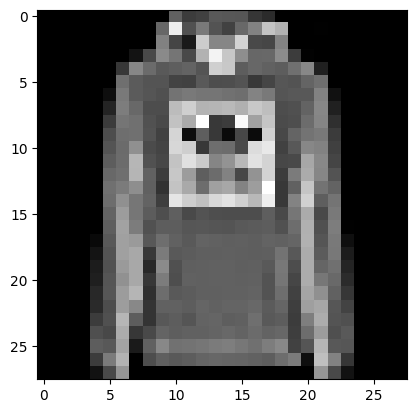

In [21]:
import matplotlib.pyplot as plt
plt.imshow(img.squeeze(), cmap="gray")

# Create a model

In [22]:
import torch
from torch import nn

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

Using cpu device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.06
----------------------------------------------------------------


Hopefully, you recognize the setup from the `linearmodel` notebook. 

- We will `Flatten` the image. That means we will transform our (64, 1, 28, 28) data into (64, 784) shaped data. What we do here, is flattening the image into a one dimensional vector.
- We have a stack of hidden layers. These are essentially dotproducts. Our vector of 784 (28*28) elements is transformed into 512 elements, and then into 10 elements because we have 10 classes.
- in between the linear transformations you can see the activation functions,here a `ReLu` 
- The `forward` method is what is called during training. This gives you control over the flow of information: it is easy to create some parallel flow of data if you want to do something like that.

# Optimizer

We need an optimizer. We will dive into this in later lessons.

For now, it is enough to know this:

Your model makes a prediction. But how does the model know if it is right, or wrong?
And, more specific: how does the model know which weights it needs to modify in order

In [23]:
import torch.optim as optim
loss_fn = torch.nn.CrossEntropyLoss()

# Learn the weights

In [24]:
from pathlib import Path
log_dir=Path("../../models/test").resolve()

In [26]:
from mltrainer import metrics
accuracy = metrics.Accuracy()

In [28]:
from mltrainer import TrainerSettings, ReportTypes, Trainer

settings = TrainerSettings(
    epochs=3,
    metrics=[accuracy],
    logdir=log_dir,
    train_steps=len(train),
    valid_steps=len(valid),
    reporttypes=[ReportTypes.TENSORBOARD],
)
settings

epochs: 3
metrics: [Accuracy]
logdir: /Users/rgrouls/code/ML22/models/test
train_steps: 937
valid_steps: 156
reporttypes: [<ReportTypes.TENSORBOARD: 2>]
optimizer_kwargs: {'lr': 0.001, 'weight_decay': 1e-05}
scheduler_kwargs: {'factor': 0.1, 'patience': 10}
earlystop_kwargs: {'save': False, 'verbose': True, 'patience': 10}

In [30]:
trainer = Trainer(
    model=model, 
    settings=settings, 
    loss_fn=loss_fn,
    optimizer=optim.Adam, 
    traindataloader=trainstreamer, 
    validdataloader=validstreamer, 
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
    )

2023-06-30 12:53:38.728 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to /Users/rgrouls/code/ML22/models/test/20230630-1253
2023-06-30 12:53:38.732 | INFO     | mltrainer.trainer:__init__:65 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


In [31]:
trainer.loop()

100%|██████████| 937/937 [00:06<00:00, 153.04it/s]
2023-06-30 12:53:45.583 | INFO     | mltrainer.trainer:report:170 - Epoch 0 train 0.4992 test 0.4941 metric ['0.8115']
100%|██████████| 937/937 [00:06<00:00, 138.04it/s]
2023-06-30 12:53:52.966 | INFO     | mltrainer.trainer:report:170 - Epoch 1 train 0.3591 test 0.3702 metric ['0.8661']
100%|██████████| 937/937 [00:06<00:00, 135.22it/s]
2023-06-30 12:54:00.469 | INFO     | mltrainer.trainer:report:170 - Epoch 2 train 0.3241 test 0.3727 metric ['0.8655']
2023-06-30 12:54:00.470 | INFO     | mltrainer.trainer:__call__:213 - best loss: 0.3702, current loss 0.3727. Counter 1/10.
100%|██████████| 3/3 [00:21<00:00,  7.20s/it]


# Save the model

You will have the latest model at trainer.model, or just use the old model (which is the same)

In [27]:
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

If you have a look at the settings.earlystop_kwargs, you can see that save is by default false. If you change this to true, the trainer would have kept track of the best model so far and saved it in between. Because this can take up additional time and in a learning setting like we are in we typically dont really want to save the model for later use, we dont need it here.

However, in a real life setting you probably want the best model!

In [28]:
settings.earlystop_kwargs

{'save': False, 'verbose': True, 'patience': 10}

You can save it manually

In [29]:
model_dir = Path("../../models").resolve()
print(f'modeldir exists: {model_dir.exists()}')
modelpath = model_dir / "trained_model"
torch.save(model, modelpath)

modeldir exists: True


In the case you would have set the earlystop.save to true like this:

In [ ]:
settings = TrainerSettings(
    epochs=10,
    metrics=[accuracy],
    logdir=log_dir,
    train_steps=len(train_dataloader),
    valid_steps=len(test_dataloader),
    tunewrite=["tensorboard"],
    earlystop_kwargs={'save': True, 'verbose': True, 'patience': 10}
)

The trainer would have saved checkpoints of the last best model. You can obtain the location of the checkpoint with `trainer.early_stopping.path`

In [30]:
trainer.early_stopping.path

PosixPath('/workspaces/ML22/models/test/20230602-1037/checkpoint.pt')

# load the model

In [31]:
loaded_model = torch.load(modelpath)

Get a batch $X$, $y$ and make a prediction $\hat{y}$

In [33]:
X, y = next(iter(testloader))
yhat = loaded_model(X)
yhat.shape

torch.Size([64, 10])

Check the accuracy:
- for every example we have 10 numbers
- the location with the highest value is the prediction
- we can get the index with `argmax` over dimension 1
- we compare that index with the original number
- This gives us a count of all the correct predictions
- dividing that through the total length gives us the accuracy percentage. 

In [34]:
acc = (yhat.argmax(dim=1) == y).sum() / len(y)
acc.item() * 100

93.75

Note that this is the accuracy for a single batch! 
Get another batch by running next() in the cell above, and calculate the accuracy again.